# Kalman Filter Application in Dynamic Positioning System 

My main goal of this study is to understand how to apply kalman filter by using Python. I wanted to choose an example from a real life scenerio. As I had experience working onboard a ship with Dynamic Positioning (DP) system, I knew that kalman filter is widely used in the system.

Before starting the study, I should explain what is the Dynamic Positioning System and how is the kalman filter used in DP systems.

Especially in the offshore industry, DP system is widely used to automatically maintain a marine platform's (either a ship or an offshore platform) position, heading (yaw angle), follow survey routes, conduct berthing or docking maneavours. These platforms have multiple thrusters (propellers) and multiple sensors (GPS, wind, current, IMU sensors, acoustic transponders, laser rangefinders etc). 

For a position keeping scenario, imagine the platform is on the location where we want to keep her position. One can measure her position from multiple GPS sensors. And if acoustic transponders are used, one can also see the relative position of the platform from these transponders. In reality, sensor data can be noisy and unstable. At the same time external forces like wind or current speed and direction can change over time. External forces can cause a drift in the platform's position. Every time the position information changes, the DP system commands thrusters to get the platform back into her desired position. If the system uses these unstable and noisy data, it can command thrusters unnecessarily and this can cause more of a position drift. Kalman filter is used to in order to discard these noisy data and estimate a stable position information. For more information about the kalman filter and it's use in DP system, I would recommend you to check resources at the end of this study. 

In reality, DP system configuration is much more complex than this definition of mine, but I wanted to explain the basics of the procedure. In order to simplfy the problem, I didn't use velocity, accelaration, wind, current data. I used only position data (x and y axes). And I followed these steps:
1. Defining number of steps (or time period).
* Defining actual (physical) position of the ship. In order to simplfy the study x and y axes are used instead of geographic coordinates.
* Creating imaginary, noisy position measuremants with the same number of steps.
* Creating empty arrays to save calculated measurements after kalman filter is applied.
* Defining related matrices for mathematical calculations.
* Conducting calculations and saving measurements.
* Visualising the actual, noisy measurements and estimated positions.

## Kalman Filter

There are amazing resources to learn about kalman filters, and I would recommend to check the resources at the end of this study. But I need to define some of the mathematical steps in order to clarify my study.

### System State
First of all, we have our ship's state (which is the position). This state is represented with x and consists of position information on x and y axes. Because I am not going to use control inputs in this study, there isn't any 'B' or 'u' matrices. And we have our state measurement which is z.

$$ x_{k} = Ax_{k–1} + Bu_{k – 1} + w_{k – 1} $$

$$ z_{k} = Hx_{k} + v_{k} $$

'w' is the process noise and 'v' is the measurement noise. And we assume they have normal probabilty distribution. Process noise has a process noise covariance of 'Q' and measurement has a measurement noise covariance of 'R'.

$$ p(w) \text{~} N(0, Q) $$
$$ p(v) \text{~} N(0, R) $$

### Kalman Filter Cycle

Steps can be summarized as follows: 
1. Calculate a priori estimate  

    $ x^{ˆ-}_k = A x^{ˆ-}_{k-1} $
   

2. Calculate a priori noise covariance

    $ P^{-}_k = A P_{k-1} A^{T} + Q $
    

3. Calculate kalman gain
    
    $  K_k = \frac{P^{-}_k C^{T}}{C P^{-}_k C^{T} + R} $ 
    

4. Calculate a posteriori estimate

    $  x^{ˆ}_k = x^{ˆ-}_k + K_k (z_{k} - C x^{ˆ-}_k)   $


5. Calculate a posteriori noise covariance

    $ P_k = (I - K_k C)P^{-}_k  $
    

6. Use a posteriori estimate and noise covariance as new a priori estimate and covairance, and repeat the steps.

### Matrix Operations
As an example let's look at a priori estimate calculation. The ship's position information consists of x and y values. So our a priori estimate is a matrix. 

$$ x^{ˆ-}_k = \begin{bmatrix} Posx_k \\ Posy_k \end{bmatrix} 
= A
\begin{bmatrix} Posx_{k-1} \\ Posy_{k-1} \end{bmatrix}
$$ 

To be able to conduct matrix operation above, we should have A matrix of (2x2). Similarly we should consider B, H, I, K, P, Q, R matrices properly. This process is different for each application and depends on our system's mathematical model. Because I dind't use ship velocity, wind, current or IMU sensor data, I only needed (2x1), (2x2) shaped matrices.

In [101]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from numpy.linalg import inv

## 1. Defining number of steps (or time period)

In [102]:
n_iters = 50

## 2. Defining actual (physical) position of the ship

In [103]:
# Actual position of the ship
actual_x = 0
actual_y = 0

# Process noise covariance which is assumed to be a small value.
Q = np.full((2,2), 0.0001)
print('Q matrix: ', Q.shape, '\n\n', Q)

Q matrix:  (2, 2) 

 [[0.0001 0.0001]
 [0.0001 0.0001]]


## 3. Creating imaginary, noisy position measuremants with same number of steps.

Normally distributed noisy measurements for x and y values are created here. 

In [104]:
# Create 50 random x and y position measurements
x_pos = np.random.normal(0, 0.5, n_iters)
y_pos = np.random.normal(0, 0.5, n_iters)

# Combine the measurements in a matrix
measurements = np.stack((x_pos, y_pos), axis=1).reshape((n_iters,2,1))

print('Measurements: ', measurements.shape, '\n\n', measurements[0:5], '\n', '...')

Measurements:  (50, 2, 1) 

 [[[ 0.64544581]
  [-0.42449482]]

 [[ 0.92932439]
  [ 0.57850016]]

 [[-0.36139572]
  [-0.65502123]]

 [[-0.03357634]
  [-0.22994698]]

 [[-0.23329244]
  [ 0.75642983]]] 
 ...


We need to define our measurement noise covariance. Change in R matrix can be examined in the position estimates. Because R is going to be used in kalman gain.

In [105]:
# Measurement noise covariance.
R = np.diag([0.25, 0.25])
print('R matrix: ', R.shape, '\n\n', R)

R matrix:  (2, 2) 

 [[0.25 0.  ]
 [0.   0.25]]


## 4. Creating empty arrays

Empty arrays are created to save estimated positions after the kalman filter is applied.

In [106]:
# Creating empty matrices
x_hat = np.zeros((n_iters, 2,1))
P = np.zeros((n_iters,2,2))
x_hat_min = np.zeros((n_iters, 2,1))
P_min = np.zeros((n_iters,2,2))
K = np.zeros((n_iters,2,2))

Initial position of the ship and initial error covariance should be defined. A high value of initial error covariance is chosen here. But one can see the error covariance will decrease with the successive steps.

In [107]:
# Initial state
x_hat[0] = [[0],[0]]

# Initial error covariance
P[0] = np.diag([1000.0, 1000.0])

print('x_hat[0]:\n\n', x_hat[0], '\n\n P[0] matrix: ', P[0].shape, '\n\n', P[0])

x_hat[0]:

 [[0.]
 [0.]] 

 P[0] matrix:  (2, 2) 

 [[1000.    0.]
 [   0. 1000.]]


## 5. Defining related matrices for mathematical calculations.

In [108]:
# A matrix
A = np.array([[1.0, 0.0],
               [0.0, 1.0]])

# H matrix
H = np.eye(2)

# Unit matrix for Kalman gain
I = np.eye(2)

print('A matrix \n\n', A, '\n\n H matrix \n\n', H, '\n\n I matrix \n\n', I)

A matrix 

 [[1. 0.]
 [0. 1.]] 

 H matrix 

 [[1. 0.]
 [0. 1.]] 

 I matrix 

 [[1. 0.]
 [0. 1.]]


## 6. Conducting calculations and saving measurements.

In [109]:
for k in range(1, n_iters):
    # Calculating a priori estimate and error covariance
    x_hat_min[k] = A.dot(x_hat[k-1])
    P_min[k] = A.dot(P[k-1]).dot(A.T) + Q
    
    # Calculating Kalman gain
    S = H.dot(P_min[k]).dot(H.T) + R
    K[k] = P_min[k].dot(H.T).dot(inv(S))
    
    # Calculating a posteriori estimate and error covariance
    x_hat[k] = x_hat_min[k] + K[k].dot(measurements[k] - H.dot(x_hat_min[k]))
    P[k] = (I - K[k]).dot(P_min[k])

## 7. Visualising the actual, noisy measurements and estimated positions.

Actual position is plotted in red, noisy measurements are plotted in orange and kalman filtered estimates are plotted in blue for x and y coordinates.

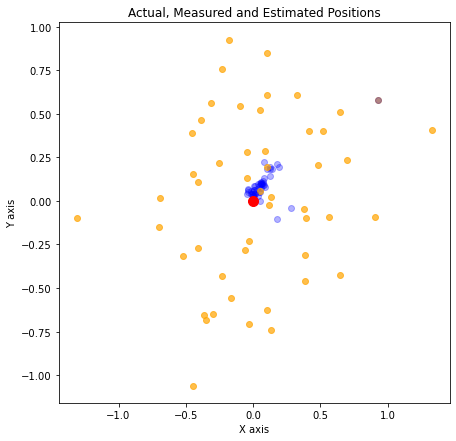

In [112]:
plt.figure(figsize=(7,7))
for n in range(n_iters):
    plt.scatter(float(measurements[n][0]), float(measurements[n][1]), 
                color='orange', label='measured position', alpha=0.7)
    plt.scatter(float(x_hat[n][0]), float(x_hat[n][1]), 
                color='blue', label='kalman position', alpha=0.3)

plt.scatter(actual_x, actual_y, color='red', s=100, label='actual position')
plt.title('Actual, Measured and Estimated Positions')
plt.xlabel('X axis')
plt.ylabel('Y axis');

Actual position, measurements and estimates for x and y values are plotted seperately through the steps. 

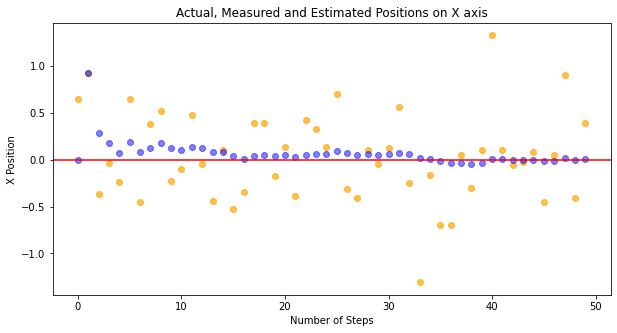

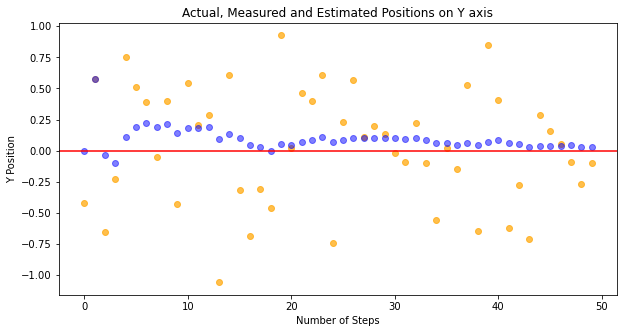

In [113]:
plt.figure(figsize=(10,5))
for n in range(n_iters):
    plt.scatter(x = n, y = measurements[n][0], label='measurements', color='orange', alpha=0.7)
    plt.scatter(x = n, y = x_hat[n][0], label='estimate after kalman', color='blue', alpha=0.5)
plt.axhline(actual_x, color='r', label='actual x position')
plt.title('Actual, Measured and Estimated Positions on X axis')
plt.xlabel('Number of Steps')
plt.ylabel('X Position')

plt.figure(figsize=(10,5))
for n in range(n_iters):
    plt.scatter(x = n, y = measurements[n][1], label='measurements', color='orange', alpha=0.7)
    plt.scatter(x = n, y = x_hat[n][1], label='estimate after kalman', color='blue', alpha=0.5)
plt.axhline(actual_x, color='r', label='actual x position')
plt.title('Actual, Measured and Estimated Positions on Y axis')
plt.xlabel('Number of Steps')
plt.ylabel('Y Position');

Visualizing measurements and estimated positions in an animation.

In [124]:
# Creating a pandas dataframe for animation
x_position = []
y_position = []
data_type = []
n_steps = []

for n in range(n_iters):
    x_position.append(float(measurements[n][0]))
    y_position.append(float(measurements[n][1]))
    data_type.append('measured')
    n_steps.append(int(n))
    
for n in range(n_iters):
    x_position.append(float(x_hat[n][0]))
    y_position.append(float(x_hat[n][1]))
    data_type.append('estimated')
    n_steps.append(int(n))

df = pd.DataFrame({'x_position':x_position,
                   'y_position':y_position,
                   'data_type':data_type,
                   'n_steps':n_steps})

# Creating the animation
import plotly.express as px

fig = px.scatter(df, 
                 x ="x_position", 
                 y ="x_position", 
                 animation_frame ="n_steps",
                 animation_group ="data_type",
                 color ="data_type",
                 facet_col ="data_type",
                 range_x=[-3, 3], 
                 range_y=[-3, 3])
fig.show()

One can see from above, kalman filtered estimates converge near the actual position as the iterations progress. 

With this basic application, I wanted to demonstrate how to use kalman filter to stabilize noisy position data. Similarly noisy wind, current and acoustic position data can be stabilized before usage. This study can be improved by defining mathematical model of the ship and adding velocity, acceleration, wind and current data to the related matrices.

**Resources:**

Great video explanations:\
https://www.youtube.com/watch?v=mwn8xhgNpFY&list=PLn8PRpmsu08pzi6EMiYnR-076Mh-q3tWr&ab_channel=MATLAB

Detailed video explanations:\
https://www.youtube.com/watch?v=CaCcOwJPytQ&feature=youtu.be&ab_channel=MichelvanBiezen

One dimensional kalman filter approach:\
https://towardsdatascience.com/kalman-filters-a-step-by-step-implementation-guide-in-python-91e7e123b968

One dimensional kalman filter with Python:\
https://scipy-cookbook.readthedocs.io/items/KalmanFiltering.html

Multi dimensional kalman filter approach:\
https://medium.com/@jaems33/understanding-kalman-filters-with-python-2310e87b8f48

Introduction to kalman filter:\
https://www.cs.unc.edu/~welch/media/pdf/kalman_intro.pdf

Kalman filtering and DP applications:\
https://dynamic-positioning.com/proceedings/dp2003/design_cadet.pdf
